In [1]:
from torchvision.transforms import Resize
from utils import *
from models.latentdiscovery.utils import load_generator
from torchvision.utils import save_image
import numpy as np
import random
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.nn as nn
import matplotlib.pylab as plt
import torchvision
from models.latentdiscovery.latent_deformator import LatentDeformator
from IPython import display
from ortho_utils import torch_expm
%matplotlib inline

StyleGAN2 load fail: No module named 'StyleGAN2'


In [2]:
def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)

## Configurations

In [3]:
random_seed = random.randint(0,1000)
set_seed(random_seed)
print(random_seed)
load_codes = True
algo = 'ortho'
root_dir= '/home/adarsh/PycharmProjects/disentagled_latent_dirs'
result_path = os.path.join(root_dir,  'results/biggan/latent_discovery_ours/qualitative_analysis')

467


## Model Selection

In [4]:
deformator_path = os.path.join(root_dir, 'pretrained_models/deformators/LatentDiscovery/biggan_imagenet/deformator_0.pt')
ld_deformator_ = torch.load(deformator_path, map_location=torch.device('cpu'))
ld_deformator = torch.FloatTensor(ld_deformator_['log_mat_half'])
ld_deformator = torch_expm((ld_deformator - ld_deformator.transpose(0, 1)).unsqueeze(0)).T

deformator_path = os.path.join(root_dir, 'results/biggan/latent_discovery_ours/models/40000_model.pkl')
dse_deformator = torch.load(deformator_path, map_location='cpu')['deformator']
dse_deformator_ = torch.FloatTensor(dse_deformator['log_mat_half'])
dse_deformator = torch_expm((dse_deformator_ - dse_deformator_.transpose(0, 1)).unsqueeze(0)).T

        
generator = load_generator(None, model_name='biggan_imagenet', gan_type = 'BigGAN')
generator.eval().cuda()

# if load_codes:
#     codes = np.load(os.path.join(root_dir, 'pretrained_models/latent_codes/pggan_celebahq1024_latents.npy'))
#     codes = torch.from_numpy(codes).type(torch.FloatTensor).cuda()
#     codes = torch.load(os.path.join(root_dir, 'results/celeba_hq/closed_form_ours/quantitative_analysis/z_analysis.pkl'))
# else:
num_samples = 1000
codes = torch.randn(num_samples,120).cuda()

In [5]:
ld_deformator_['log_mat_half'].shape

torch.Size([120, 120])

#  Plot only one deformator latent traversal

In [6]:
# def postprocess_images(images):
#         """Post-processes images from `torch.Tensor` to `numpy.ndarray`."""
#         images = images.detach().cpu().numpy()
#         images = (images + 1) * 255 / 2
#         images = np.clip(images + 0.5, 0, 255).astype(np.uint8)
#         images = images.transpose(0, 2, 3, 1)
#         return images



# def save_images(codes, bias, shifts_r, shifts_count, cf_dir,generator, cf_deformator):
#         plt.figure(figsize=(30,30))
#         for idx, z in enumerate(codes):
#             print('Figure : ' + str(idx))
#             z_shift_cf = []
#             for i, shift in enumerate(np.linspace(-shifts_r,shifts_r,shifts_count)):
#                 direction = cf_deformator[cf_dir: cf_dir + 1] 
#                 direction = direction.unsqueeze(2)
#                 direction = direction.unsqueeze(3)
#                 z_shifted = z.view(1,512,1,1) +  direction* shift + bias.view(-1,512,1,1)
#                 z_shift_cf.append(z_shifted)
#             z_shift_cf = torch.stack(z_shift_cf)
#             z_shift_cf = z_shift_cf.squeeze(1)
#             with torch.no_grad():
#                 cf_images= generator(z_shift_cf)
#             temp_path = os.path.join(result_path, 'temp')
#             os.makedirs(temp_path, exist_ok = True)
#             torch.save(cf_images, os.path.join(temp_path, 'cf.pkl'))
#             del cf_images
#             cf_images = torch.load(os.path.join(temp_path, 'cf.pkl'))
#             all_images = cf_images
#             grid = torchvision.utils.make_grid(all_images.clamp(min=-1, max=1),nrow=10, scale_each=True, normalize=True)
#             display.display(plt.gcf())
#             plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
#             del all_images
#             del cf_images
#             del grid

    
# z_min_index = 0
# z_max_index = 10
# cf_dir = 19
# shift_r = 10
# shift_count = 10
# all_images = save_images(codes[z_min_index:z_max_index],cf_bias, shift_r, shift_count, cf_dir, generator, cf_deformator)                    

In [7]:

import numpy as np
import torch
from torchvision.transforms import Resize
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from PIL import Image
import io
import os

from torch_tools.visualization import to_image

def make_noise(batch, dim, truncation=None):
    if isinstance(dim, int):
        dim = [dim]
    if truncation is None or truncation == 1.0:
        return torch.randn([batch] + dim)
    else:
        return torch.from_numpy(truncated_noise([batch] + dim, truncation)).to(torch.float)

      
def is_conditional(G):
    return 'biggan' in G.__class__.__name__.lower()


def one_hot(dims, value, indx):
    vec = torch.zeros(dims)
    vec[indx] = value
    return vec


def fig_to_image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    return Image.open(buf)


@torch.no_grad()
def interpolate(G, z, shifts_r, shifts_count, dim, deformator=None, with_central_border=False):
    shifted_images = []
    for shift in np.arange(-shifts_r, shifts_r + 1e-9, shifts_r / shifts_count):
        if deformator is not None:
            latent_shift = deformator(one_hot(deformator.input_dim, shift, dim).cuda())
        else:
            latent_shift = one_hot(G.dim_shift, shift, dim).cuda()
        shifted_image = G.gen_shifted(z, latent_shift).cpu()[0]
        if shift == 0.0 and with_central_border:
            shifted_image = add_border(shifted_image)

        shifted_images.append(shifted_image)
    return shifted_images


def add_border(tensor):
    border = 3
    for ch in range(tensor.shape[0]):
        color = 1.0 if ch == 0 else -1
        tensor[ch, :border, :] = color
        tensor[ch, -border:,] = color
        tensor[ch, :, :border] = color
        tensor[ch, :, -border:] = color
    return tensor


@torch.no_grad()
def make_interpolation_chart(G, deformator=None, z=None,
                             shifts_r=10.0, shifts_count=5,
                             dims=None, dims_count=10, texts=None, **kwargs):
    with_deformation = deformator is not None
    if with_deformation:
#         deformator_is_training = deformator.training
        deformator.eval()
    z = z if z is not None else make_noise(1, G.dim_z).cuda()

    if with_deformation:
        original_img = G(z).cpu()
    else:
        original_img = G(z).cpu()
    imgs = []
    if dims is None:
        dims = range(dims_count)
    for i in dims:
        imgs.append(interpolate(G, z, shifts_r, shifts_count, i, deformator))

    rows_count = len(imgs) + 1
    fig, axs = plt.subplots(rows_count, **kwargs)

    axs[0].axis('off')
    axs[0].imshow(to_image(original_img, True))

    if texts is None:
        texts = dims
    for ax, shifts_imgs, text in zip(axs[1:], imgs, texts):
        ax.axis('off')
        plt.subplots_adjust(left=0.5)
        ax.imshow(to_image(make_grid(shifts_imgs, nrow=(2 * shifts_count + 1), padding=1), True))
        ax.text(-20, 21, str(text), fontsize=10)

#     if deformator is not None and deformator_is_training:
#         deformator.train()

    return fig


@torch.no_grad()
def inspect_all_directions(G, deformator, out_dir, zs=None, num_z=3, shifts_r=8.0):
    os.makedirs(out_dir, exist_ok=True)

    step = 5
    max_dim = G.dim_shift
    zs = zs if zs is not None else make_noise(num_z, G.dim_z).cuda()
    torch.save(zs,'z_temp.pth')
    shifts_count = zs.shape[0]

    for start in range(0, max_dim - 1, step):
        imgs = []
        dims = range(start, min(start + step, max_dim))
        for z in zs:
            z = z.unsqueeze(0)
            fig = make_interpolation_chart(
                G, deformator=deformator, z=z,
                shifts_count=shifts_count, dims=dims, shifts_r=shifts_r,
                dpi=250, figsize=(int(shifts_count * 4.0), int(0.5 * step) + 2))
            fig.canvas.draw()
            plt.close(fig)
            img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            # crop borders
            nonzero_columns = np.count_nonzero(img != 255, axis=0)[:, 0] > 0
            img = img.transpose(1, 0, 2)[nonzero_columns].transpose(1, 0, 2)
            imgs.append(img)

        out_file = os.path.join(out_dir, '{}_{}.jpg'.format(dims[0], dims[-1]))
        print('saving chart to {}'.format(out_file))
        Image.fromarray(np.hstack(imgs)).save(out_file)


def gen_animation(G, deformator, direction_index, out_file, z=None, size=None, r=8):
    import imageio

    if z is None:
        z = torch.randn([1, G.dim_z], device='cuda')
    interpolation_deformed = interpolate(
        G, z, shifts_r=r, shifts_count=5,
        dim=direction_index, deformator=deformator, with_central_border=False)

    resize = Resize(size) if size is not None else lambda x: x
    img = [resize(to_image(torch.clamp(im, -1, 1))) for im in interpolation_deformed]
    imageio.mimsave(out_file, img + img[::-1])

# Plot comparison for both deformators

258
Figure : 0


<Figure size 2160x2160 with 0 Axes>

Figure : 1


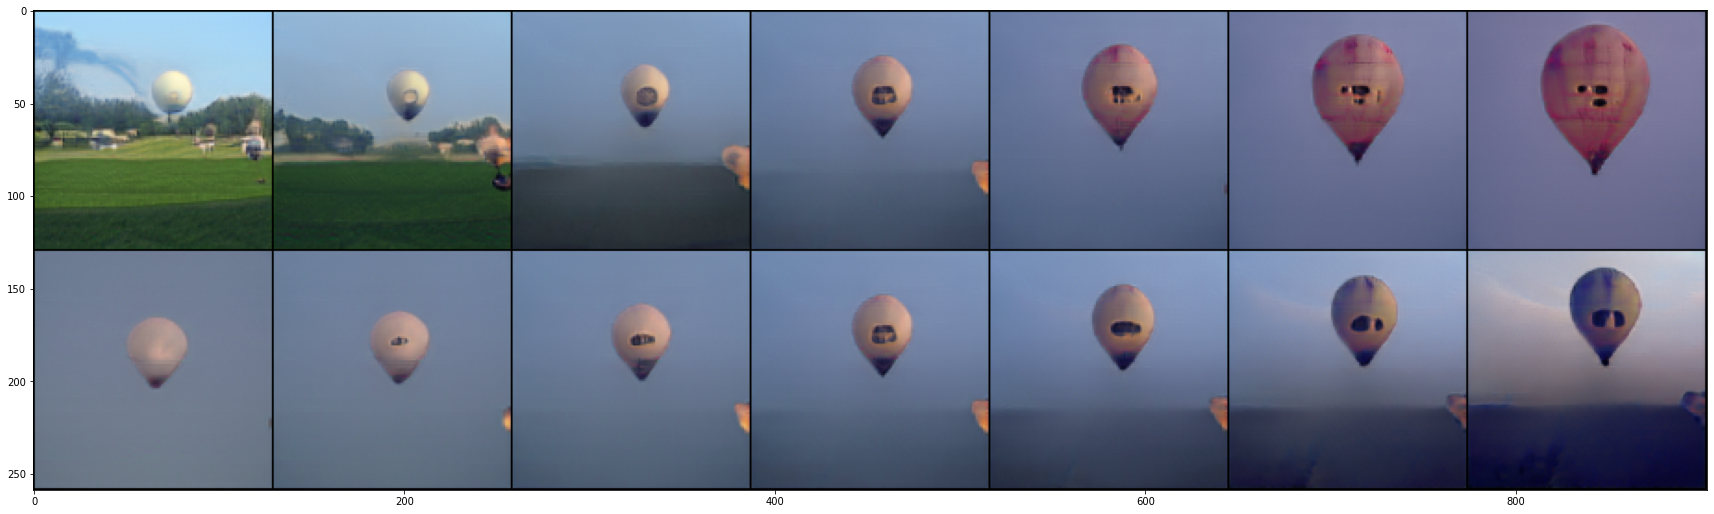

Figure : 2


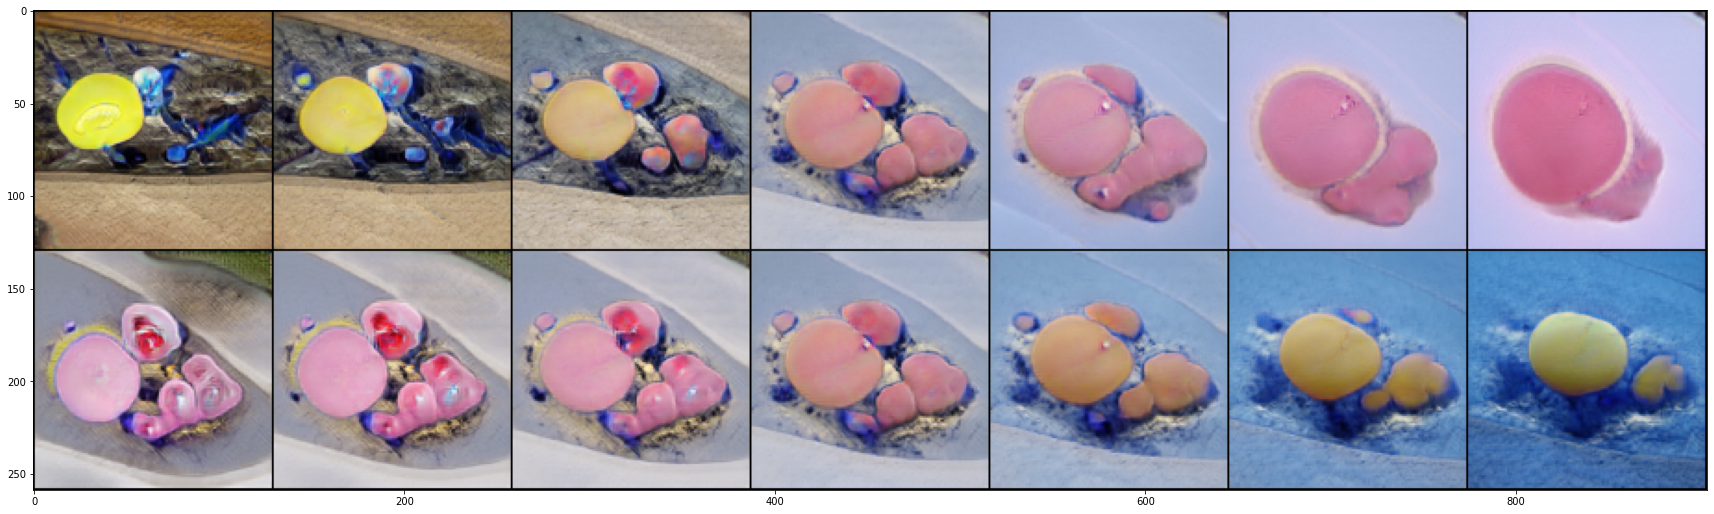

Figure : 3


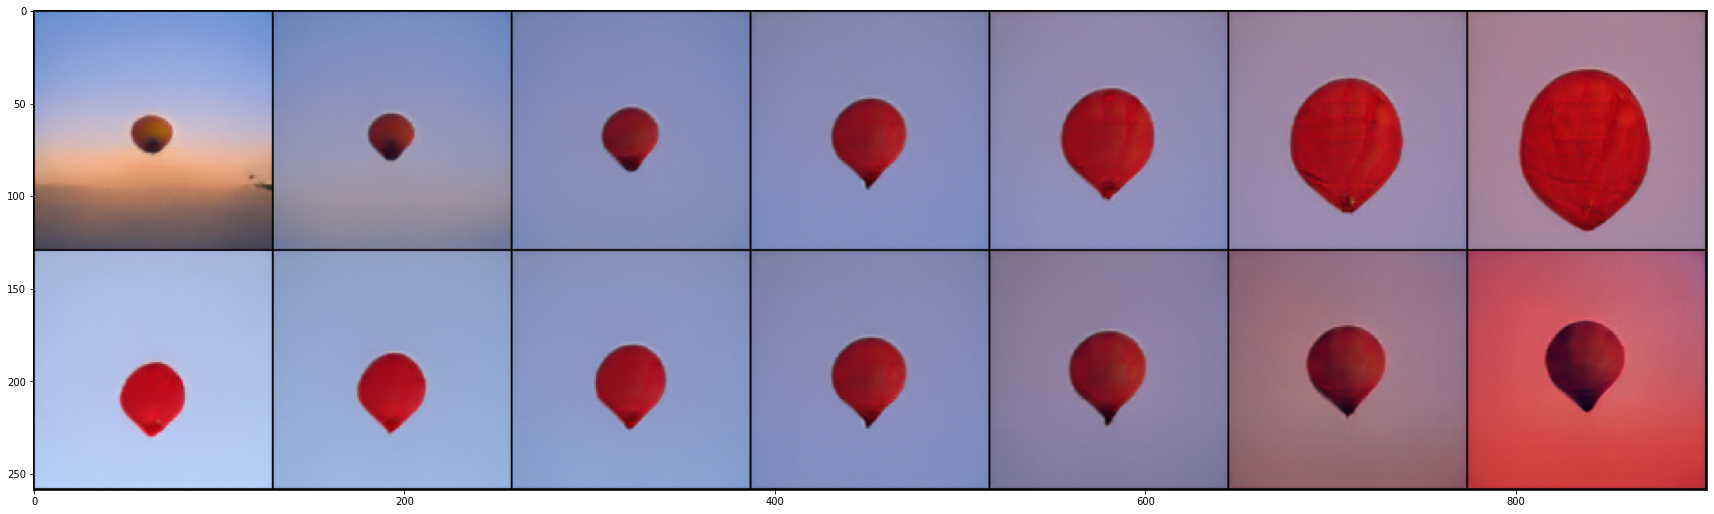

Figure : 4


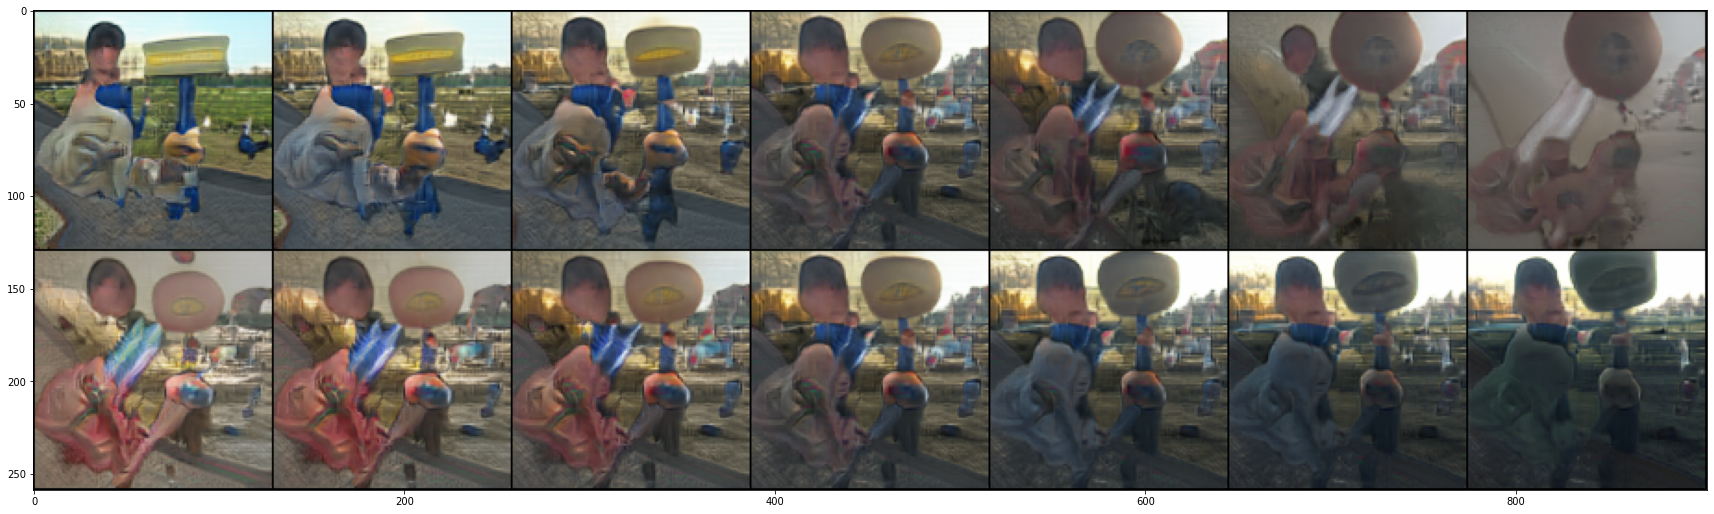

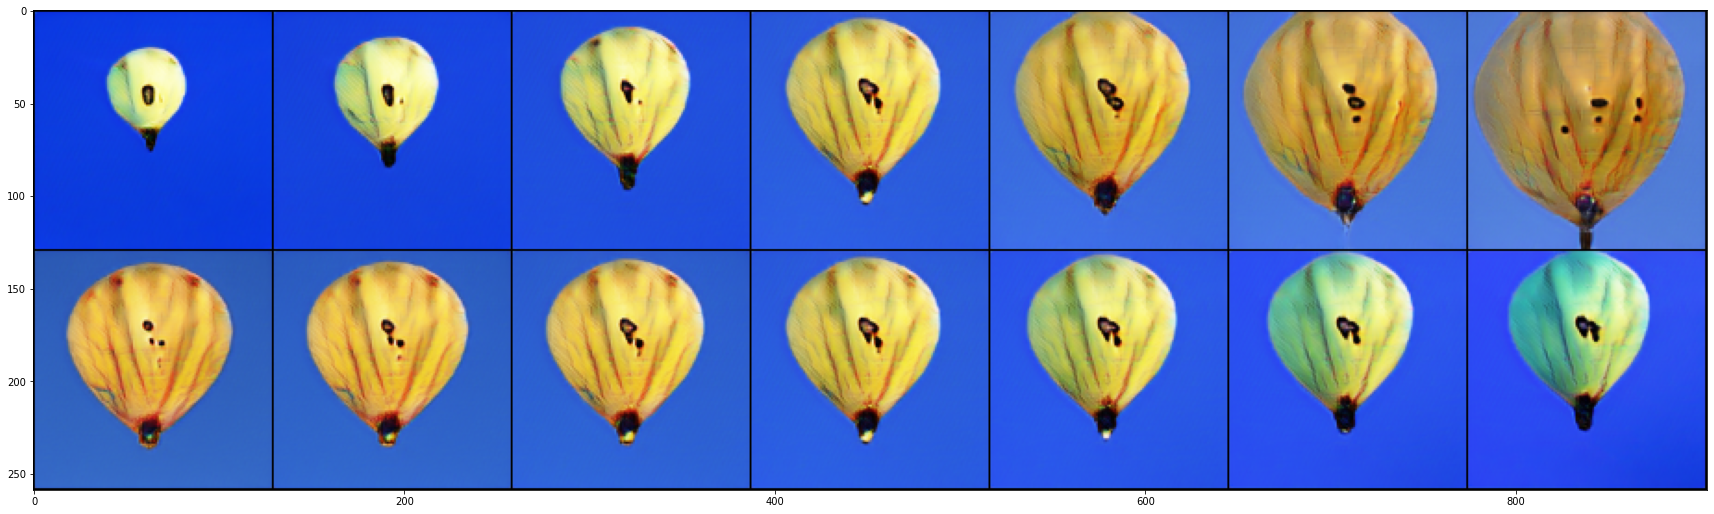

In [8]:

def save_images(codes, shifts_r, shifts_count, cf_dir, dse_dir, generator, cf_deformator, dse_deformator):
        classes = random.randint(0,999)
        print(classes)
#         generator.set_classes(239)
        generator.set_classes(417)
        plt.figure(figsize=(30,30))
#         plt.axis('off')
        temp_path = os.path.join(result_path, 'temp')
        os.makedirs(temp_path, exist_ok=True)
        for idx, z in enumerate(codes):
            print('Figure : ' + str(idx))
            z_shift_cf = []
            z_shift_dse = []
            for i, shift in enumerate(np.linspace(-shifts_r,shifts_r,shifts_count)):
                direction = ld_deformator[cf_dir: cf_dir + 1] 
                z_shifted = z + (direction * shift).cuda()
                z_shift_cf.append(z_shifted)
                
                direction = dse_deformator[dse_dir: dse_dir + 1]  
                z_shifted = z +  (direction * shift).cuda()
                z_shift_dse.append(z_shifted)
                
            z_shift_cf = torch.stack(z_shift_cf).squeeze(dim=1)
            z_shift_dse = torch.stack(z_shift_dse).squeeze(dim=1)
            classes = generator.mixed_classes(z_shift_cf.shape[0])

            with torch.no_grad():
                cf_images= generator(z_shift_cf)
            torch.save(cf_images, os.path.join(temp_path, 'cf.pkl'))
            del cf_images
            with torch.no_grad():
                dse_images= generator(z_shift_dse)
            torch.save(dse_images, os.path.join(temp_path, 'dse.pkl'))
        
            del dse_images
            cf_images = torch.load(os.path.join(result_path, 'temp', 'cf.pkl'))
            dse_images = torch.load(os.path.join(result_path, 'temp', 'dse.pkl'))
            all_images = torch.cat((cf_images, dse_images), dim=0)
            grid = torchvision.utils.make_grid(all_images.clamp(min=-1, max=1),nrow=7,padding=1, normalize=True)
            display.display(plt.gcf())
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            del all_images
            del cf_images
            del dse_images
            del grid

    
z_min_index = 10
z_max_index = 15
cf_dir = 22
dse_dir = 27
shift_r = 8
shift_count = 7
all_images = save_images(codes[z_min_index:z_max_index], shift_r, shift_count, cf_dir, dse_dir, generator, ld_deformator, dse_deformator)                    

In [ ]:
generator.set_classes(417)
deformator = LatentDeformator(shift_dim = generator.dim_z,input_dim=120,out_dim = generator.dim_z,type = 'ortho')
deformator.log_mat_half.data = dse_deformator_
deformator.cuda()
zs = torch.stack([codes[2],codes[3],codes[8]])

inspect_all_directions(generator, deformator, '/home/adarsh/PycharmProjects/sefa-master/lat', zs=zs, num_z=3, shifts_r=8.0)